# Fresh Idea
## separate one/zero activity of domains
- replace zeros by minus one
- calculate the class activity for 3 hours bins for each domain
- calculate the user activity for gaussian around center of 3 hour bins
- calculate the likelihood of the person being a 1/-1 in that time 
- add user general metrics including domain cls activity and usage patterns

### questions
- how to take into account times when the person used a website when others didnt?
- how to give likelihood when the person didn't show any nearby activity?
- what if he used a similar website at same time but more nich? 
- how to average the bins weighted by the significance of that bin?
- how to give weight to the magnitude of number of users entering? probability of 1 with confidence
- what about sparse websites?
- how to not let times where there are no activity take a lot of weight?
### enhancements
- create graph embedding of urls
- for each bin, calculate the metric per url
- instead of only looking at the specific website, take into account websites with similar usages,
  for example looking at same domain_cls usage in gaussian around bin, or looking at domain embeddings and looking at the activity in similar embeddings weighted by the distance in the embedding space

### NOTICE:
the data itself will use all domains, even ones that the person never used. this could be an issue. 
first of all the fact that the person doesnt use them is an indication. we 
- we might want to take the niche websites and sum them up
- we might want to remove them

IDEA!
- use different features for different people
- make an ensemble that can differentiate between different users
- take the people that get a wrong prediction and see if a classifier that is more "fringe" can classify them better
- for example another tree classifier that takes a smaller amount of features to give more opportunity to fringe websites
can create a classifier for each user type 
can take number of usages for each domain, and cluster people or PCA
clustering is good - I can create a classifier for each cluster, from each cluster take all of the available data for all of the visited domains, and create a classifier for them. use only data from those users or all users that used one of the websites, plus the general model, for each cluster - use cluster model and general model.
also - I can multiply the features by the log of usages

another idea is to simply average the most prominent websites weighted by the specific user usages, and the general usage

USER CLUSTER AS FEATURE - or PCA coefficients

an idea - see how chaotic are the subject's patterns, if it's too predictable then it might be a bot


## Options for getting good scores for low data people
### low activity enhancement:
- use selected features as initial centroids for domain clustering (spherical kmeans with initial centroids)
- impute selected features only for these people
### using highly visited websites:
- filter urls that more than 3-5 people visited
- simple option: give a score per website which is baysian probability
- deeper option : take all urls of highly visited websites
    - take 12-24 hour bits - and connect a trail from user to timebin to 1/0, then to all urls, where it increments the edge score by 1
    - get embedding (32-64)
    - use umap to turn to manifold with 8-16 dims
    - cluster the urls using kmeans or spectral clustering
    - for each person, give score for each cluster, how many urls from each cluster.
### model engineering
- create a model for low data people, for all people and for high data people
- create a model for non-content features like psd
- give sample weights
- do different regularization - very high regularization ,gamma so that not one feature takes all the credit.

### Environment Initialization

In [ ]:
import sys
sys.path.append("/home/tom.touati/mafat-challenge/code/submission")
import importlib
import os
import ray
from modin.config import NPartitions,RangePartitioning
%matplotlib widget
os.environ["NEPTUNE_API_TOKEN"] = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMGMyZjIyZC0xMjQzLTQxNjQtYjZjZC0wMTRiZmJmZmRlZjYifQ=="
    # !export MODIN_CPUS=2
# n_cpus = 8
plasma_store_size = 170*(1024**3)
heap_memory = 200*(1024**3)
# os.environ["MODIN_CPUS"] = str(n_cpus)
# os.environ["MODIN_ENGINE"] = "ray"
os.environ["MODIN_NPARTITIONS"] = "30"
os.environ["MODIN_RANGE_PARTITIONING"] = "True"
# os.environ["MODIN_MEMORY"] = str(plasma_store_size)
ray.init(num_cpus =30,ignore_reinit_error=True, object_store_memory=plasma_store_size,_memory=heap_memory)
# print(ray.cluster_resources())
import modin.pandas as mpd
from modin import config as cfg
print(vars(cfg))
NEPTUNE_MODE="sync"
params={}
%load_ext autoreload
%autoreload 2

### Data Loading & Preparation

In [322]:
%%writefile submission/load_and_prepare_input.py
import os
import sqlite3
# %matplotlib widget
import matplotlib.pyplot as plt
from multiprocessing import freeze_support
from modin.db_conn import ModinDatabaseConnection
import modin.pandas as mpd


# Modin will use Ray
# ray.init()
# NPartitions.put(16)
def load_domain_data_from_db(con, domain_cls=False, only_domain=False):
    try:
        device_ids_query = f"""SELECT Datetime,Device_ID,Domain_Name,Target from data
        WHERE Domain_Name != 1732927
        """

        # WHERE Domain_Name != 1732927 """
        df = mpd.read_sql(device_ids_query, con)._repartition()
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise


def load_cls_data_from_db(con, domain_cls=False, only_domain=False):
    try:
        device_ids_query = f"""SELECT Datetime,Device_ID,Domain_cls1,Domain_cls2,Domain_cls3,Domain_cls4,Target
        from data
        WHERE Domain_Name != 1732927
        """
        df = mpd.read_sql(device_ids_query, con)._repartition()
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

# prepare training data
import matplotlib.pyplot as plt
#train test split
from sklearn.model_selection import train_test_split


def get_train_test_devices(device_target_df, test_size=0.2, random_state=43):
    # Perform stratified split on device IDs
    train_device_ids, test_device_ids = train_test_split(
        device_target_df['Device_ID'],
        test_size=test_size,
        random_state=random_state,
        stratify=device_target_df['Target'])
    return train_device_ids, test_device_ids


def get_initial_train_data(db_df,
                           test_size=0.2,
                           random_state=42,
                           min_domain_devices=10,
                           n_devices_hist=False):
    device_targets = db_df.groupby("Device_ID")["Target"].first().reset_index()
    train_devices, test_device_ids = get_train_test_devices(
        device_targets, test_size=test_size, random_state=random_state)
    train_df = db_df[db_df["Device_ID"].isin(train_devices)]
    devices_per_domain = train_df.groupby("Domain_Name")["Device_ID"].nunique()

    domain_mask = devices_per_domain > min_domain_devices
    print(
        f"Percentage of domains with more than {min_domain_devices} devices: {domain_mask.mean()*100:.2f}%"
    )
    devices_per_domain = devices_per_domain[domain_mask]
    if n_devices_hist:
        hist = devices_per_domain.hist()
        # run["plots/domain_devices_hist"].upload(neptune.types.File.as_image(hist.figure))
        plt.show()
    train_df = train_df[train_df["Domain_Name"].isin(devices_per_domain.index)]
    return train_df, train_devices, test_device_ids, device_targets, devices_per_domain

def load_url_data_from_db(con):

    try:
        device_ids_query = f"""SELECT Datetime,Device_ID,URL,Target
        from data
        WHERE Domain_Name != 1732927
        """
        df = mpd.read_sql(device_ids_query, con)._repartition()
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise


def load_and_prepare_data(data_type="domain"):
    freeze_support()
    dbfile = '../../data/training_set.db'

    conn = ModinDatabaseConnection('sqlalchemy', f'sqlite:///{dbfile}')

    # Can use get_connection to get underlying sqlalchemy engine
    conn.get_connection()
    if data_type == "domain":
        db_df = load_domain_data_from_db(conn)
    elif data_type == "cls":
        db_df = load_cls_data_from_db(conn)
    elif data_type == "url":
        db_df = load_url_data_from_db(conn)
    print(db_df.head())
    del conn
    db_df['Datetime'] = mpd.to_datetime(db_df['Datetime'])
    db_df.set_index('Datetime', inplace=True)
    if data_type == "domain":
        db_df = db_df.astype({
            'Domain_Name': 'uint32',
            'Device_ID': 'uint32',
            'Target': 'uint8'
        })
    elif data_type == "cls":
        db_df = db_df.astype({
            'Device_ID': 'uint32',
            'Domain_cls1': 'uint32',
            'Domain_cls2': 'uint32',
            'Domain_cls3': 'uint32',
            'Domain_cls4': 'uint32',
            'Target': 'uint32'
        })
    else:
        db_df = db_df.astype({
            'URL': 'uint32',
            'Device_ID': 'uint32',
            'Target': 'uint8'
        })
    return db_df
# Add this line

Overwriting submission/load_and_prepare_input.py


In [ ]:
from submission.domain_timeseries_processing import *
from submission.utils import *
from submission.load_and_prepare_input import *
from submission.prepare_and_train_model import *
from submission.content_based_features import *
from submission.frequency_base_feats import *
from submission.cls_features import *

db_df = load_and_prepare_data()

params.update({
    "training_data": {
        "min_domain_devices": 10,
        "n_devices_hist": False,
        "test_size": 0.3,
        "random_state": 47
    }
})
train_df, train_devices, test_device_ids, device_targets, devices_per_valid_domain = get_initial_train_data(
    db_df, **params["training_data"])
train_df = train_df._repartition()

### Utils

In [ ]:
%%writefile submission/utils.py
import numpy as np
import modin.pandas as mpd
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def z_normalize_by_all(df,
                       train_devices,
                       per_column=True,
                       fillval=0,
                       fill_na_pre_transform=False,
                       scaler=None):
    if scaler is not None:
        if fill_na_pre_transform:
            df.fillna(fillval, inplace=True)
        df.iloc[:, :] = scaler.transform(
            df if per_column else df.values.reshape(-1, 1)).reshape(df.shape)
        if fillval is not None:
            df.fillna(fillval, inplace=True)
        return
    scaler = StandardScaler()
    train_data = df.loc[train_devices]
    scaler.fit(train_data if per_column else train_data.values.reshape(-1, 1))

    # Transform all data using fitted scaler
    if fill_na_pre_transform:
        df.fillna(fillval, inplace=True)
    df.iloc[:, :] = scaler.transform(
        df if per_column else df.values.reshape(-1, 1)).reshape(df.shape)
    if fillval is not None:
        df.fillna(fillval, inplace=True)
        
    params = {
        "mean_":
        [float(x)
         for x in scaler.mean_],  # Convert to list for JSON serialization
        "var_": [float(x) for x in scaler.var_],
        "scale_": [float(x) for x in scaler.scale_],
        "n_samples_seen_": [int(x) for x in scaler.n_samples_seen_]
        if isinstance(scaler.n_samples_seen_, np.ndarray) else int(
            scaler.n_samples_seen_),
    }
    return params


def min_max_scale_all_values(df, train_devices, per_column=False, scaler=None):
    if scaler is not None:
        df.iloc[:, :] = scaler.transform(
            df if per_column else df.values.reshape(-1, 1)).reshape(df.shape)
        return
    # Create MinMaxScaler and fit on training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data = df.loc[train_devices]
    scaler.fit(train_data if per_column else train_data.values.reshape(-1, 1))

    # Transform all data using fitted scaler
    df.iloc[:, :] = scaler.transform(
        df if per_column else df.values.reshape(-1, 1)).reshape(df.shape)

    # Save scaler parameters as JSON
    scaler_params = {
        "min_": float(scaler.min_[0]),  # Convert to native Python float
        "scale_": float(scaler.scale_[0]),
        "data_min_": float(scaler.data_min_[0]),
        "data_max_": float(scaler.data_max_[0]),
        "data_range_": float(scaler.data_range_[0]),
        # Convert tuple to list for JSON
        "feature_range": list(scaler.feature_range)
    }
    return scaler_params


from sklearn.impute import KNNImputer  # , IterativeImputer
from sklearn.linear_model import BayesianRidge
from scipy.sparse import csr_matrix


# from implicit.cpu.als import AlternatingLeastSquares
def impute_missing_values(final_scores_pivot, train_device_ids):
    # Use SoftImpute to fill missing values
    imputer = KNNImputer(n_neighbors=10)
    imputer.fit(final_scores_pivot.loc[train_device_ids])
    imputed_scores = imputer.transform(final_scores_pivot)
    # imputer = AlternatingLeastSquares(factors=10, regularization=0.01, iterations=10,random_state=0)
    # # imputer = MissForest(max_depth=6,max_features=0.8, random_state=0)
    # imputer.fit( user_items = csr_matrix(final_scores_pivot.loc[train_device_ids].values))

    # imputed_scores = imputer.recommend_all(csr_matrix(final_scores_pivot.values))
    return imputed_scores


import gc
import ctypes
import sys


def cleanup_memory():
    """
    Force cleanup of memory by:
    1. Running garbage collection
    2. Attempting to release memory back to OS
    """
    # Force garbage collection
    gc.collect()

    # Attempt to release memory back to the OS
    if sys.platform.startswith('linux'):
        libc = ctypes.CDLL('libc.so.6')
        # MALLOC_TRIM(0) releases memory back to OS if possible
        print(libc.malloc_trim(0))

### URL BASED

In [ ]:

def filter_urls(url_df,threshold=10):
    devices_per_url = url_df.groupby("URL")["Device_ID"].nunique()
    devices_per_url = devices_per_url[devices_per_url >= threshold]
    url_df = url_df[url_df["URL"].isin(devices_per_url.index)]._repartition()
    return url_df
def get_target_per_url(url_df, train_devices):
    # Get the number of unique URLs
    nunique_urls = url_df["URL"].nunique()
    train_url_df = url_df[url_df["Device_ID"].isin(train_devices)]
    train_url_df = train_url_df._repartition()
    target_per_url = train_url_df.groupby(["URL", "Target"])["Device_ID"].nunique()
    target_per_url = target_per_url.unstack().fillna(0).astype(int)
    target_per_url["p_1"] = target_per_url[1] / target_per_url.sum(axis=1)
    target_per_url_reduced = target_per_url[(target_per_url["p_1"] -
                                            0.5).abs() > 0.1]
    target_per_url_reduced[
        "n_devices"] = target_per_url_reduced[0] + target_per_url_reduced[1]

    target_per_url_reduced["weighted_p1"] = target_per_url_reduced[
        "p_1"] * target_per_url_reduced["n_devices"]
    print(
        f"Number of Filtered URLS: {len(target_per_url_reduced)}"
    )
    return target_per_url_reduced
def calculate_user_url_score(url_df, target_per_url_reduced):
    # Calculate the user URL score

    user_url_df = url_df.groupby(["Device_ID", "URL"]).first().reset_index()
    url_df_merged = user_url_df[["Device_ID", "URL"
                                ]].set_index("URL").join(target_per_url_reduced,
                                                        how="inner")
    user_url_score = url_df_merged.groupby("Device_ID")[[
        "weighted_p1", "n_devices"
    ]].sum()
    user_url_score[
        "score"] = user_url_score["weighted_p1"] / user_url_score["n_devices"]
    user_url_score = user_url_score[["score"]]
    unique_devices = list(set(url_df["Device_ID"]))
    user_url_score = user_url_score.T.reindex(columns=unique_devices).fillna(0.5).T
    return user_url_score

In [389]:
url_df = load_and_prepare_data("url")
url_df = filter_urls(url_df,threshold=10)
target_per_url_reduced = get_target_per_url(url_df, train_devices)
user_url_score = calculate_user_url_score(url_df, target_per_url_reduced)
user_url_score = user_url_score.astype(np.float32)
url_score_scaler = z_normalize_by_all(user_url_score,
                                      train_devices,
                                      per_column=True,
                                      fill_na_pre_transform=False)

In [ ]:
@ray.remote
def get_user_url_graph_edges(user_df):
    device_id = user_df["Device_ID"].iloc[0]
    target = user_df["Target"].iloc[0]
    edges = user_df["URL"].resample("1H").apply(
        lambda x: [(x.iloc[i],x.iloc[i+1]) for i in range(len(x)-1)]+[(
            f"device_{str(device_id)}",f"target_{str(target)}"),(
            f"target_{str(target)}",x.iloc[0])])
    return edges
    
for device_id in train_devices:
    device_url_df = url_df[url_df["Device_ID"] == device_id]
    device_url_df = device_url_df._repartition()
    user_edges = get_user_url_graph_edges.remote(device_url_df)

edges_df = mpd.concat([
    mpd.DataFrame(edges_list,
                    columns=["source", "destination"]).set_index("source")
    for edges_list in ray.get(user_edges) 
])

### Domain Timeseries Base Features

In [412]:
%%writefile submission/domain_timeseries_processing.py
import json
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from functools import partial
import ray


def process_activity_timeseries(domain_df,
                                bin_hours=6,
                                gaussian_filter=True,
                                n_days_each_side=3,
                                std=1.5,
                                drop_na=True,
                                drop_zeros=False):
    activity_per_3h = domain_df[["Device_ID"
                                 ]].resample(f'{str(bin_hours)}h').nunique()
    activity_per_3h.rename(columns={"Device_ID": "Activity"}, inplace=True)
    # activity_per_3h = activity_per_3h.to_frame()

    # n_days_each_side * 24h / 3h_per_bin * 2 sides
    gaussian_window_hours = int(n_days_each_side * 24 / bin_hours * 2)
    if gaussian_filter:
        activity_per_3h = activity_per_3h.rolling(window=gaussian_window_hours,
                                                  win_type='gaussian',
                                                  center=True,
                                                  min_periods=1,
                                                  closed="both").mean(std=std)
    if drop_na:
        activity_per_3h.dropna(inplace=True)
    if drop_zeros:
        activity_per_3h = activity_per_3h[activity_per_3h["Activity"] != 0]
    return activity_per_3h.round().astype(int)


def _calculate_p1_if_active(domain_activity_timeseries):
    domain_activity_timeseries["bin_activity"] = domain_activity_timeseries["Activity_0"] + \
        domain_activity_timeseries["Activity_1"]
    domain_activity_timeseries["total_domain_activity"] = (
        domain_activity_timeseries["target_domain_activity_0"] +
        domain_activity_timeseries["target_domain_activity_1"])
    domain_activity_timeseries["relative_bin_activity"] = domain_activity_timeseries["bin_activity"] / \
        domain_activity_timeseries["total_domain_activity"]
    domain_activity_timeseries["p_Active|0"] = domain_activity_timeseries[
        "Activity_0"] / (domain_activity_timeseries["0_users"])
    domain_activity_timeseries["p_active|1"] = domain_activity_timeseries[
        "Activity_1"] / (domain_activity_timeseries["1_users"])
    domain_activity_timeseries["p_1"] = domain_activity_timeseries[
        "1_users"] / (domain_activity_timeseries["0_users"] +
                      domain_activity_timeseries["1_users"])
    domain_activity_timeseries["p_active"] = domain_activity_timeseries[
        "bin_activity"] / (domain_activity_timeseries["0_users"] +
                           domain_activity_timeseries["1_users"])
    domain_activity_timeseries["p_1|active"] = domain_activity_timeseries[
        "p_active|1"] * (domain_activity_timeseries["p_1"] /
                         domain_activity_timeseries["p_active"])
    pass


def get_domain_activity_timeseries(train_df, domain_ts_kwargs,col="Domain"):
    process_domain_timeseries = partial(process_activity_timeseries,
                                        **domain_ts_kwargs)
    process_domain_timeseries.__name__ = process_activity_timeseries.__name__
    domain_timeseries = train_df[[col, "Target",
                                  "Device_ID"]].groupby([
                                      col, "Target"
                                  ]).apply(process_domain_timeseries)
    domain_timeseries["activity_fraction"] = domain_timeseries.groupby(
        [col, "Target"]).transform(lambda x: x / x.sum())
    # Add the sum of activity as a new column
    domain_activity = domain_timeseries.groupby([col, "Target"
                                                 ])[["Activity"]].sum()
    domain_activity = domain_activity.rename(
        columns={"Activity": "target_domain_activity"})
    # Merge the results
    domain_timeseries = domain_timeseries.merge(domain_activity,
                                                left_index=True,
                                                right_index=True)
    # Reset index to get Target as a column, then pivot to get Target as columns
    pivot_fraction_ts = domain_timeseries.reset_index().pivot(
        index=['Datetime', col], columns='Target').fillna(0)
    pivot_fraction_ts.columns = [
        f'{col[0]}_{col[1]}' for col in pivot_fraction_ts.columns
    ]
    target_users_per_domain = train_df.groupby([
        col, "Target"
    ])["Device_ID"].nunique().unstack().fillna(0).astype(int).rename(
        columns={
            0: "0_users",
            1: "1_users"
        })
    pivot_fraction_ts = pivot_fraction_ts.reset_index("Datetime").join(
        target_users_per_domain,
        how="left").set_index("Datetime", append=True).swaplevel()
    _calculate_p1_if_active(pivot_fraction_ts)
    return pivot_fraction_ts


def get_user_activity_timeseries(db_df, user_ts_kwargs,col="Domain_Name"):
    process_user_timeseries = partial(process_activity_timeseries,
                                      **user_ts_kwargs)
    process_user_timeseries.__name__ = process_activity_timeseries.__name__
    user_timeseries = db_df[[col, "Device_ID"
                             ]].groupby([col, "Device_ID"
                                         ]).apply(process_user_timeseries)
    return user_timeseries


def get_user_domain_scores(domain_activity_timeseries,
                           user_activity_timeseries,col="Domain_Name"):
    # Merge domain and user timeseries data more efficiently
    merged_timeseries_df = domain_activity_timeseries[[
        "p_1|active", "bin_activity"
    ]].reset_index().merge(user_activity_timeseries.reset_index(),
                           how="inner",
                           on=[col, "Datetime"]).set_index(
                               ["Datetime", col, "Device_ID"])

    # Filter for active periods first to reduce data size
    merged_timeseries_df = merged_timeseries_df[
        merged_timeseries_df["Activity"] > 0]

    # Calculate scores directly
    # Calculate relative activity using transform for vectorized operation
    group_sums = merged_timeseries_df.groupby(
        [col, 'Device_ID'])['bin_activity'].transform('sum')

    # Vectorized division
    merged_timeseries_df[
        'relative_active_bins_activity'] = merged_timeseries_df[
            'bin_activity'] / group_sums

    # Calculate weighted scores in one step
    merged_timeseries_df["weighted_score"] = (merged_timeseries_df["p_1|active"]) * \
        (merged_timeseries_df["relative_active_bins_activity"])

    # Get final scores with optimized groupby
    final_scores = merged_timeseries_df.groupby(["Device_ID", col
                                                 ])["weighted_score"].sum()

    # Create pivot table efficiently
    final_scores_pivot = final_scores.unstack()

    return final_scores_pivot


import matplotlib.pyplot as plt
import numpy as np


def get_weighted_final_scores(final_scores_pivot,
                              domain_usage_proportion,
                              square_usage=False):
    # plt.figure()
    mult = domain_usage_proportion[final_scores_pivot.columns]
    if square_usage:
        mult = mult**2
    weighted_final_scores = final_scores_pivot.mul(mult)

    # target_features = device_targets.set_index("Device_ID").join(weighted_final_scores)
    # target_features.set_index("Target")[[int(x) for x in best_features if x.isnumeric()]].stack().groupby("Target").mean().plot(kind="bar")
    # plt.show()
    return weighted_final_scores
    # with open('submission/minmax_scaler.json', 'w') as f:
    #     json.dump(scaler_params, f)

Overwriting submission/domain_timeseries_processing.py


In [411]:
params.update({
    "domain_activity_timeseries": {
        "bin_hours": 6,
        "gaussian_filter": True,
        "n_days_each_side": 7,
        "std": 1.5,
        "drop_na": False,
        "drop_zeros": True
    }
})

params.update({
    "user_activity_timeseries": {
        "bin_hours": 6,
        "gaussian_filter": True,
        "n_days_each_side": 3,
        "std": 1.5,
        "drop_na": True,
        "drop_zeros": False
    }
})
domain_activity_timeseries = get_domain_activity_timeseries(
    train_df, params["domain_activity_timeseries"])

db_df_valid_mask = db_df["Domain_Name"].isin(devices_per_valid_domain.index)
user_activity_timeseries = get_user_activity_timeseries(
    db_df.loc[db_df_valid_mask], params["user_activity_timeseries"])

p_scores_df = get_user_domain_scores(domain_activity_timeseries,
                                     user_activity_timeseries)
p_scores_df -= 0.5
# print("Why minmax here? it possibly creates a bias")
# # prob_score_scaler_params = min_max_scale_all_values(p_scores_df, train_devices)

NameError: name 'train_df' is not defined

### Content Usage Based Features

In [ ]:
%%writefile submission/content_based_features.py
import numpy as np


def get_domain_usage_proportion(db_df):
    res = db_df.groupby("Device_ID")["Domain_Name"].value_counts(
        normalize=True).unstack(fill_value=0).astype(np.float32)
    return res


def get_proportion_of_domains_visited(df,n_total_domains=None):
    res = df.groupby(
        "Device_ID")["Domain_Name"].nunique() / (df["Domain_Name"].nunique() 
                                                 if n_total_domains is None else n_total_domains)
    res.name = "n_domains"
    return res.to_frame()


In [ ]:
domain_usage_proportion = get_domain_usage_proportion(
    db_df.loc[db_df["Domain_Name"].isin(devices_per_valid_domain.index)])
max_domain_usage = domain_usage_proportion.max(axis=1).to_frame()
max_domain_usage.columns.to_frame().to_parquet(
    "submission/max_domain_usage_cols.parquet")
max_domain_scaler = z_normalize_by_all(max_domain_usage,
                                       train_devices,
                                       per_column=True)
domain_usage_proportion = np.log(1 + domain_usage_proportion)
domain_usage_proportion = ((domain_usage_proportion.T) /
                           domain_usage_proportion.T.max()).T
# del cls_data

### Frequency Based Features


In [ ]:
%%writefile submission/frequency_base_feats.py
import numpy as np
from sklearn.decomposition import PCA


def get_active_days_per_user(user_domain_ts):
    """
    Calculate the number of unique days each user had any activity.

    Args:
        user_domain_ts: MultiIndex Series with levels [Domain_Name, Device_ID, Datetime]

    Returns:
        Series with index Device_ID and values being number of unique active days
    """
    # Reset index to get Datetime as a column
    df = user_domain_ts.reset_index()

    # Convert Datetime to date (removing time component)
    df['Date'] = df['Datetime'].dt.date

    # Group by Device_ID and count unique dates where Activity > 0
    active_days = df[df['Activity'] > 0].groupby('Device_ID')['Date'].nunique()

    active_days = active_days.astype(int)
    active_days.name = "Active_Days"
    active_days = (active_days - active_days.min()) / (
        active_days.max() - active_days.min()) * 2 - 1
    return active_days


def get_activity_per_time_bin(df, bin_hours=3):
    # Convert datetime to time only
    # time_index = db_df.index.to_series().dt.time
    # df["time"] = time_index
    df_copy = df.copy()
    df_copy["time"] = db_df.index.to_series().dt.hour.astype(int) // bin_hours
    df_copy["day_part_activity"] = 0
    activity_per_time_range = df_copy[[
        "Device_ID", "time", "day_part_activity"
    ]].groupby(["Device_ID", "time"]).count()
    activity_per_time_range[
        "activity_fraction"] = activity_per_time_range.groupby(
            "Device_ID").apply(lambda x: x / x.sum()).values
    activity_per_time_range = activity_per_time_range[["activity_fraction"
                                                       ]].reset_index()
    activity_per_time_range = activity_per_time_range.pivot(
        index="Device_ID", columns="time", values="activity_fraction")
    activity_per_time_range.columns = [
        f"time_{col}" for col in activity_per_time_range.columns
    ]
    activity_per_time_range = (
        activity_per_time_range - activity_per_time_range.stack().min()) / (
            activity_per_time_range.stack().max() -
            activity_per_time_range.stack().min()) * 2 - 1
    activity_per_time_range = activity_per_time_range.fillna(0)
    return activity_per_time_range  # .round().astype(int)


#activity fft
from scipy import fft
import numpy as np
from sklearn.preprocessing import StandardScaler


def get_ps_df(db_df, pd,cols=None):
    device_activity_ts = db_df.groupby("Device_ID")["Domain_Name"].resample(
        "3H").count()
    device_activity_ts = device_activity_ts.unstack().fillna(0)
    if cols is not None:
        device_activity_ts = device_activity_ts.reindex(cols,axis="columns").fillna(0)
    # Apply Hann window to the data before FFT
    window = np.hanning(device_activity_ts.shape[1])
    device_activity_ts = device_activity_ts * window
    # device_activity_ts = StandardScaler().fit_transform(device_activity_ts.T)
    power_spectrums = np.abs(fft.rfft(device_activity_ts, axis=1))**2

    sample_d = 3 * 60 * 60

    freqs = fft.rfftfreq(device_activity_ts.shape[1], d=sample_d)
    freq_mask = freqs >= 0
    power_spectrums = power_spectrums[:, freq_mask]
    freqs = freqs[freq_mask]

    psd_df = pd.DataFrame(power_spectrums,
                          index=device_activity_ts.index,
                          columns=freqs)
    # Get power spectra for training devices only

    return psd_df


# Convert to dataframe and normalize
# power_spectrums_df = power_spectrums.to_frame('power_spectrum')
# power_spectrums_df = (power_spectrums_df - power_spectrums_df.min()) / (power_spectrums_df.max() - power_spectrums_df.min())

In [ ]:
cleanup_memory()
psd_df = get_ps_df(db_df, mpd)
psd_df.columns.to_frame().to_parquet("submission/psd_df_cols.parquet")

psd_df_scaler_params = z_normalize_by_all(psd_df,
                                          train_devices,
                                          per_column=True)
domains_visited_proportion = get_proportion_of_domains_visited(
    db_df[db_df["Domain_Name"].isin(devices_per_valid_domain.index)])
print("ADD DOMAIN VISITED PROPORTION FROM SELECTED_FEATURES"
      )  #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
domains_visited_proportion.columns.to_frame().to_parquet(
    "submission/domains_visited_proportion_cols.parquet")
domains_visited_scaler_params = z_normalize_by_all(domains_visited_proportion,
                                                   train_devices,
                                                   per_column=True,
                                                   fillval=0)

### CLS Features

In [118]:
# %%writefile submission/cls_features.py
import numpy as np


def get_cls_proportion(df):
    cols = ["Domain_cls1", "Domain_cls2", "Domain_cls3", "Domain_cls4"]
    df = df.set_index("Device_ID")[cols].stack()
    df = df[df != 0]
    df.index = df.index.droplevel(1)
    df = df.groupby("Device_ID").value_counts(normalize=True).unstack().astype(
        np.float32)
    return df


In [ ]:
# del db_df
# del train_df
# del domain_activity_timeseries
# del user_activity_timeseries
cleanup_memory()

In [ ]:
# cls_data = load_and_prepare_data("cls")

cls_proportion = get_cls_proportion(cls_data)
cls_proportion.columns.to_frame().to_parquet(
    "submission/cls_proportion_cols.parquet")
cls_proportion_scaler = z_normalize_by_all(cls_proportion,
                                           train_devices,
                                           per_column=True,
                                           fill_na_pre_transform=True)


#train cls



# print("Why minmax here? it possibly creates a bias")
# # prob_score_scaler_params = min_max_scale_all_values(p_scores_df, train_devices)

In [414]:
params.update({
    "cls_activity_timeseries": {
        "bin_hours": 6,
        "gaussian_filter": True,
        "n_days_each_side": 7,
        "std": 1.5,
        "drop_na": False,
        "drop_zeros": True
    }
})

params.update({
    "user_col_activity_timeseries": {
        "bin_hours": 6,
        "gaussian_filter": True,
        "n_days_each_side": 3,
        "std": 1.5,
        "drop_na": True,
        "drop_zeros": False
    }
})
# cls_ts = cls_data.set_index(["Device_ID", "Target"],
#                             append=True).drop(columns="Domain_Name").replace(
#                                 0, np.nan).stack(dropna=True)
# cls_ts.index = cls_ts.index.droplevel(-1)
# cls_ts = cls_ts.rename("cls").reset_index(["Target", "Device_ID"])
# train_cls = cls_ts[cls_ts["Device_ID"].isin(train_devices)]
# train_cls = train_cls._repartition()
# domain_cls_activity_timeseries = get_domain_activity_timeseries(
#     train_cls, params["cls_activity_timeseries"], col="cls")

# user_cls_activity_timeseries = get_user_activity_timeseries(
#     cls_ts, params["user_col_activity_timeseries"], col="cls")

cls_p_scores_df = get_user_domain_scores(domain_cls_activity_timeseries,
                                         user_cls_activity_timeseries,
                                         col="cls")
cls_p_scores_df -= 0.5

Falling back to a full-axis implementation.
Falling back to a TreeReduce implementation.


In [416]:
cls_p_scores_df = cls_p_scores_df.astype(np.float32).stack()

In [417]:
cls_p_scores_df = cls_p_scores_df[cls_p_scores_df.abs() > 0.1]

In [423]:
cls_proportion.stack().rename("cls_proportion").to_frame()

cls_proportion
Device_ID                    
15        2         -1.666187
          18        -0.118743
          22         0.117362
          23         0.173205
          27        -0.414512
...                       ...
69992     839       -0.300924
          841       -0.449915
          842       -0.334132
          843       -0.133313
          846       -0.494293

[1015410 rows x 1 columns]

In [421]:
cls_final_scores = cls_p_scores_df.to_frame().join(
    cls_proportion.stack().rename("cls_proportion").to_frame(), how="inner")

NotImplementedError: Index._join_level on non-unique index is not implemented

In [420]:
cls_final_scores

0    2    18   22   23   27   29   31   34   36   ...  \
Device_ID cls                                                           ...   
15        62.0   0.111919  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
          201.0 -0.121053  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
          266.0  0.126506  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
          347.0 -0.125000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
          364.0  0.103774  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
...                   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
69992     666.0  0.152245  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
          675.0  0.300000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
          749.0  0.152174  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
          770.0  0.292188  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
          846.0 -0.173317  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   

                 810  812  823  826  829  839  841  842  843  846  
Device_ID cls                                                      
15        62.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          201.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          266.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          347.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          364.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
69992     666.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          675.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          749.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          770.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          846.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[63269 rows x 166 columns]

In [ ]:
domain_cls_activity_timeseries = get_domain_activity_timeseries(
    train_cls, params["cls_activity_timeseries"],col="cls")

user_cls_activity_timeseries = get_user_activity_timeseries(
    cls_ts, params["user_col_activity_timeseries"],col="cls")

cls_p_scores_df = get_user_domain_scores(domain_activity_timeseries,
                                     user_activity_timeseries,col="cls")
cls_p_scores_df -= 0.5

Activity_0  Activity_1  \
Datetime                  Domain_Name                           
2023-04-23 00:00:00+03:00 381                 0.0         5.0   
                          462                 0.0         1.0   
                          2209                7.0         4.0   
                          3083                2.0         0.0   
                          3852                1.0         0.0   
...                                           ...         ...   
2023-05-13 18:00:00+03:00 2405642             1.0        11.0   
                          2406745             1.0         0.0   
                          2407978             2.0         2.0   
                          2408324             0.0         0.0   
                          2408371            88.0       149.0   

                                       activity_fraction_0  \
Datetime                  Domain_Name                        
2023-04-23 00:00:00+03:00 381                     0.000000   
                          462                     0.000000   
                          2209                    0.012433   
                          3083                    0.012658   
                          3852                    0.017241   
...                                                    ...   
2023-05-13 18:00:00+03:00 2405642                 0.010526   
                          2406745                 0.007246   
                          2407978                 0.009302   
                          2408324                 0.000000   
                          2408371                 0.009589   

                                       activity_fraction_1  \
Datetime                  Domain_Name                        
2023-04-23 00:00:00+03:00 381                     0.008897   
                          462                     0.027027   
                          2209                    0.006250   
                          3083                    0.000000   
                          3852                    0.000000   
...                                                    ...   
2023-05-13 18:00:00+03:00 2405642                 0.012318   
                          2406745                 0.000000   
                          2407978                 0.007380   
                          2408324                 0.000000   
                          2408371                 0.010276   

                                       target_domain_activity_0  \
Datetime                  Domain_Name                             
2023-04-23 00:00:00+03:00 381                               0.0   
                          462                               0.0   
                          2209                            563.0   
                          3083                            158.0   
                          3852                             58.0   
...                                                         ...   
2023-05-13 18:00:00+03:00 2405642                          95.0   
                          2406745                         138.0   
                          2407978                         215.0   
                          2408324                           0.0   
                          2408371                        9177.0   

                                       target_domain_activity_1  0_users  \
Datetime                  Domain_Name                                      
2023-04-23 00:00:00+03:00 381                             562.0       96   
                          462                              37.0        5   
                          2209                            640.0      271   
                          3083                              0.0       96   
                          3852                              0.0       33   
...                                                         ...      ...   
2023-05-13 18:00:00+03:00 2405642                         893.0       51   
                       

### Mixed Features

In [122]:
params.update({"weighted_final_scores": {}})  #"fillna": True}})
weighted_final_scores = get_weighted_final_scores(
    p_scores_df._repartition(), domain_usage_proportion._repartition(),
    **params["weighted_final_scores"])
weighted_final_scores.columns.to_frame().to_parquet(
    "submission/weighted_final_scores_cols.parquet")
scores_scaler = z_normalize_by_all(weighted_final_scores,
                                   train_devices,
                                   per_column=False,
                                   fill_na_pre_transform=True)


In [ ]:
plt.figure()
weighted_final_scores.stack().hist(bins=1000)
plt.xlim(-1, 1)
plt.show()

In [ ]:
params.update({
    "mean_probability_score": {
        "fillna": True,
        "square_usage": True,
        "norm": "z"
    }
})
step_params = params["mean_probability_score"]
mean_probability_score = get_weighted_final_scores(
    p_scores_df,
    domain_usage_proportion,
    square_usage=step_params["square_usage"],
).T.sum().to_frame()
proportions_used = domain_usage_proportion[p_scores_df.columns]
if params["mean_probability_score"]["square_usage"]:
    proportions_used = proportions_used**2
mean_probability_score /= proportions_used.T.sum().to_frame()
mean_probability_score.columns.to_frame().to_parquet(
    "submission/mean_probability_score_cols.parquet")
mean_scores_scaler = z_normalize_by_all(mean_probability_score,
                                        train_devices,
                                        per_column=False,
                                        fill_na_pre_transform=True)
# change this to sum,then divide by sum of usage

In [ ]:
scalers = {
    "max_domain_scaler": max_domain_scaler,
    "psd_df_scaler": psd_df_scaler_params,
    "domains_visited_scaler": domains_visited_scaler_params,
    "cls_proportion_scaler": cls_proportion_scaler,
    "weighted_score_scaler": scores_scaler,
    "mean_scores_scaler": mean_scores_scaler,
    "url_score_scaler": url_score_scaler,
}

print(scalers)
for k, v in scalers.items():
    with open(f"submission/{k}.json", 'w') as f:
        json.dump(v, f)
all_cls = cls_proportion.columns
with open("submission/cls_columns.json", 'w') as f:
    json.dump(all_cls.tolist(), f)
with open("submission/valid_domains.json", 'w') as f:
    json.dump(devices_per_valid_domain.index.tolist(), f)
with open("submission/domains_visited_proportions_cols.json", 'w') as f:
    json.dump(domains_visited_proportion.columns.to_list(), f)


### Preparation & Training

In [384]:
# %%writefile submission/prepare_and_train_model.py
# model training
import xgboost
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score


def join_features(
    device_targets,
    weighted_final_scores=None,
    domain_usage_proportion=None,
    cls_proportion=None,
    psd_df=None,
    domains_visited_proportion=None,
    mean_probability_score=None,
    max_domain_usage=None,
    user_url_score=None,
):
    final_features = device_targets.set_index(
        "Device_ID") if device_targets is not None else None

    if weighted_final_scores is not None and final_features is not None:
        final_features = final_features.join(
            weighted_final_scores.rename(columns=lambda x: "p_" + str(x)),
            how="left")
        print("weighted_final_scores")
        print(weighted_final_scores.stack().describe())
    else:
        final_features = weighted_final_scores.rename(
            columns=lambda x: "p_" + str(x))

    if domain_usage_proportion is not None:
        final_features = final_features.join(domain_usage_proportion.rename(
            columns=lambda x: "domain_usage_" + str(x)),
                                             how="left")
        print("domain_usage_proportion")
        print(domain_usage_proportion.stack().describe())
    if cls_proportion is not None:
        final_features = final_features.join(cls_proportion.rename(
            columns=lambda x: "cls_proportion_" + str(x)),
                                             how="left")
        print("cls_proportion")
        print(cls_proportion.stack().describe())
    if psd_df is not None:
        final_features = final_features.join(
            psd_df.rename(columns=lambda x: "activity_ps_" + str(x)),
            how="left")
        print("psd_df")
        print(psd_df.stack().describe())
    if domains_visited_proportion is not None:
        final_features = final_features.join(domains_visited_proportion.rename(
            columns=lambda x: "domains_visited_" + str(x)),
                                             how="left")
        print("domains_visited_proportion")
        print(domains_visited_proportion.stack().describe())
    if mean_probability_score is not None:
        final_features = final_features.join(mean_probability_score.rename(
            columns=lambda x: "mean_p_" + str(x)),
                                             how="left")
        print("mean_probability_score")
        print(mean_probability_score.stack().describe())
    if max_domain_usage is not None:
        final_features = final_features.join(max_domain_usage.rename(
            columns=lambda x: "max_domain_usage_" + str(x)),
                                             how="left")
        print("max_domain_usage")
        print(max_domain_usage.stack().describe())
    if user_url_score is not None:
        final_features = final_features.join(
            user_url_score.rename(columns=lambda x: "user_url_" + str(x)),
            how="left")
        print("user_url_score")
        print(user_url_score.stack().describe())
    # final_features = final_features.join(device_domain_PCA,how="left")
    # if active_days is not None:
    #     final_features = final_features.join(active_days,how="left")
    # if activity_per_time_range is not None:
    #     final_features = final_features.join(activity_per_time_range,how="left")
    # final_features = final_features.fillna(0)
    final_features.columns = [str(col) for col in final_features.columns]
    return final_features


def prepare_model_data(final_features, train_devices, test_device_ids):
    X_train = final_features[final_features.index.isin(train_devices)].drop(
        'Target', axis=1)
    y_train = final_features[final_features.index.isin(
        train_devices)]['Target']

    X_test = final_features[final_features.index.isin(test_device_ids)].drop(
        'Target', axis=1)
    y_test = final_features[final_features.index.isin(
        test_device_ids)]['Target']
    return X_train, y_train, X_test[X_train.columns], y_test


def train_model(X_train, y_train, X_test=None, y_test=None, params=None):

    xgb_reg = xgboost.XGBRegressor(
        **params["model"],
        eval_metric=roc_auc_score)  #,early_stopping_rounds=25)
    selector = RFE(xgb_reg, **params["feature_selection"], verbose=1)
    selector = selector.fit(
        X_train,
        y_train)  #, eval_set=[(X_train,y_train),(X_test, y_test)], verbose=1)
    best_features = list(X_train.columns[selector.support_])
    if X_test is not None:
        test_prediction = selector.estimator_.predict(X_test[best_features])
        test_auc = round(roc_auc_score(y_test, test_prediction), 3)
        return test_auc, selector, best_features, y_test, test_prediction
    return None, selector, best_features, None, None


def train_without_selection(X_train,
                            y_train,
                            X_test=None,
                            y_test=None,
                            params=None):
    xgb_reg = xgboost.XGBRegressor(
        **params["model"],
        eval_metric=roc_auc_score)  #,early_stopping_rounds=25)
    xgb_reg.fit(X_train, y_train)
    if X_test is not None:
        test_prediction = xgb_reg.predict(X_test)
        test_auc = round(roc_auc_score(y_test, test_prediction), 3)
        return test_auc, xgb_reg
    return None, xgb_reg

In [390]:
final_features = join_features(
    device_targets=device_targets,
    weighted_final_scores=weighted_final_scores,
    cls_proportion=cls_proportion,
    psd_df=psd_df,
    domains_visited_proportion=domains_visited_proportion,
    mean_probability_score=mean_probability_score,
    max_domain_usage=max_domain_usage,
    user_url_score=user_url_score,
)
# Calculate 0.5 percentile threshold for domains_visited_n_domains
percentile_threshold = np.quantile(final_features['domains_visited_n_domains'],
                                   0.5)

# Filter data to only include rows where domains_visited_n_domains is above the threshold

X_train, y_train, X_test, y_test = prepare_model_data(final_features,
                                                      train_devices,
                                                      test_device_ids)

print("data with a lot of zeros shouldnt be normalized with zscore")


weighted_final_scores
count    6.269080e+07
mean    -1.670311e-01
std      2.099191e-01
min     -7.476524e+01
25%     -1.745439e-01
50%     -1.745439e-01
75%     -1.745439e-01
max      1.057925e+02
dtype: float64
cls_proportion
count    1.015410e+06
mean    -3.171732e-01
std      7.987340e-01
min     -4.326850e+00
25%     -5.268306e-01
50%     -3.159408e-01
75%     -1.333130e-01
max      1.531167e+02
dtype: float64
psd_df
count    523090.000000
mean         -0.004298
std           0.937100
min          -0.528167
25%          -0.252210
50%          -0.144136
75%          -0.032681
max          68.705879
dtype: float64
domains_visited_proportion
count    6154.000000
mean       -0.006521
std         0.998039
min        -2.000097
25%        -0.751405
50%        -0.062312
75%         0.631406
max         4.779837
dtype: float64
mean_probability_score
count    6154.000000
mean       -0.007108
std         1.001939
min        -8.567538
25%        -0.799263
50%        -0.088344
75%         0.61

In [391]:
import json
from sklearn.metrics import confusion_matrix
import seaborn as sns
import neptune

params.update({
    "feature_selection": {
        "n_features_to_select": 2000,
        "step": 20000
    },
    "model":
    dict(seed=0,
         subsample=0.8,
         colsample_bytree=0.6,
         learning_rate=0.1,
         n_estimators=250,
         max_depth=3,
         objective='binary:logistic'),  # ,reg_lambda = 1.3 ),
    "no-normalization-finalscores":
    True
})

run = neptune.init_run(
    project="tom.touati/web-segmentation",  # replace with your project
    api_token=os.environ["NEPTUNE_API_TOKEN"],
    # name="Activity-Based Features",
    capture_stdout=True,
    capture_stderr=True,
    capture_hardware_metrics=True,
    tags=["time-based-models", "activity-based-features"],
    description="User activity patterns analysis",
    mode=NEPTUNE_MODE)
run["parameters"] = params
run["notebook"].upload(
    "/home/tom.touati/mafat-challenge/code/time_based_model.ipynb")

score, selector, best_features, y_test, test_prediction = train_model(
    X_train, y_train, X_test, y_test, params)

# score, model = train_without_selectrion(X_train, y_train, X_test, y_test,
#                                        paams)

print(f'The auc for validation set: {score}')
# calculate confusion matrix relative to prediction

run["metrics/roc_auc"] = score
# run["metrics/selected_features"] = str(best_features)
# run["metrics/feature_importances"] = str(
#     selector.estimator_.feature_importances_)
# run["metrics/feature_ranking"] = str(selector.ranking_)
# run["metrics/feature_support"] = str(selector.support_)
# # Close the run
with open("submission/best_features.json", "w") as fp:
    json.dump(best_features, fp)

run.stop()


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/tom.touati/web-segmentation/e/WEB-143
Fitting estimator with 10441 features.
The auc for validation set: 0.901
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/tom.touati/web-segmentation/e/WEB-143/metadata


In [392]:
domain_activity_timeseries.to_parquet(
    "submission/best_domains_timeseries.parquet")
target_per_url_reduced.to_parquet("submission/target_per_url_reduced.parquet")
ress = []

In [ ]:
#trying ensemble
from sklearn.ensemble import RandomForestClassifier
import numpy as np
X_train_truncated = X_train[[
    x for x in X_train.columns if not x.startswith("p_")
]]
X_test_truncated = X_test[[
    x for x in X_test.columns if not x.startswith("p_")
]]
score, model = train_without_selection(X_train_truncated,
                                       y_train,
                                       X_test=X_test_truncated,
                                       y_test=y_test,
                                       params=params)
# Create arrays of predictions from both models
model_preds = model.predict(X_train_truncated)
selector_preds = selector.estimator_.predict(X_train[best_features])

# Combine predictions into a feature matrix
X_combined = np.column_stack([model_preds, selector_preds])

# Create and train random forest with specified parameters
ensemble = RandomForestClassifier(n_estimators=20,
                                  max_depth=3,
                                  bootstrap=True,
                                  random_state=42)

# Split the test set in half for training the ensemble

# Train the ensemble
ensemble.fit(X_combined, y_train)
X_test_combined = np.column_stack([
    model.predict(X_test_truncated),
    selector.estimator_.predict(X_test[best_features])
])
# Make predictions
# Initialize and train logistic regression
lr_ensemble = LogisticRegression(random_state=42)
lr_ensemble.fit(X_train_combined, y_train)

# Make predictions on test set
ensemble_preds = lr_ensemble.predict_proba(X_test_combined)[:, 1]

# Calculate and print AUC score
ensemble_auc = roc_auc_score(y_test, ensemble_preds)
print(f'Ensemble AUC: {ensemble_auc:.4f}')

In [301]:
#heavy regularization
regularization_params = {
    "model":
    dict(
        seed=0,
        subsample=0.8,
        colsample_bytree=0.6,
        learning_rate=0.08,
        n_estimators=400,
        max_depth=3,
        objective='binary:logistic',
        reg_alpha=0.3,
    ),
}
regularization_params["reg_lambda"] = 3.0
score, regulerized_model = train_without_selection(
    X_train[best_features],
    y_train,
    X_test=X_test[best_features],
    y_test=y_test,
    params=regularization_params)

In [317]:
#imputing best features
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

best_domains = np.array(
    [int(x.replace("p_", "")) for x in best_features if x.startswith("p_")])
best_domains_significance = np.array([
    x for i, x in enumerate(selector.estimator_.feature_importances_)
    if best_features[i].startswith("p_")
])
best_domains_significance = best_domains_significance / np.sum(
    best_domains_significance)

five_best_domains = best_domains[np.argsort(best_domains_significance)[-5:]
                                 [::-1]]
nan_val = -0.1745439112923462
# Create mask where all ten best domains are equal to nan_val
all_nan_mask = final_features[best_features][[
    f'p_{domain}' for domain in five_best_domains
]].eq(nan_val).all(axis=1)

# Get features for rows that need imputation
final_imputed = final_features[best_features].copy()
final_imputed.loc[all_nan_mask].replace(nan_val, np.nan, inplace=True)

# Split into train and test
zero_train = final_imputed[final_imputed.index.isin(train_devices)]
zero_test = final_imputed[final_imputed.index.isin(test_device_ids)]
from sklearn.impute import KNNImputer
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
# Initialize and fit imputer
imputer = KNNImputer(n_neighbors=15,
                     weights='distance',
                     metric=manhattan_distances)

# imputer = IterativeImputer(
#     estimator=BayesianRidge(),
#     max_iter=10,
#     random_state=42,
#     initial_strategy='constant',
#     sample_posterior=True,
#     fill_value=nan_val,
# )
imputer.fit(zero_train)

final_imputed.iloc[:, :] = imputer.transform(final_imputed)
final_imputed["Target"] = final_features["Target"]
X_train_imp, y_train_imp, X_test_imp, y_test_imp = prepare_model_data(
    final_imputed, train_devices, test_device_ids)
score, model = train_without_selection(X_train_imp,
                                       y_train_imp,
                                       X_test_imp,
                                       y_test_imp,
                                       params=params)


In [285]:
best_domains = [
    int(x.replace("p_", "")) for x in best_features if x.startswith("p_")
]

In [ ]:
import xgboost as xgb
import xgboost as xgb

dtrain_selected = xgb.DMatrix(X_train[best_features], y_train)
dtest_selected = xgb.DMatrix(X_test[best_features], y_test)

dtrain_full = xgb.DMatrix(X_train, y_train)
deval_full = xgb.DMatrix(X_test.iloc[int(len(X_test) // 2):],
                         y_test.iloc[int(len(y_test) // 2):])
dtest_full = xgb.DMatrix(X_test.iloc[:int(len(X_test) // 2)],
                         y_test.iloc[:int(len(y_test) // 2)])


sample_weights = np.ones(X_train.shape[0])
sample_weights -= 0.1 *X_train.domains_visited_n_domains

sample_weights = X_train.domains_visited_n_domains.max(
) - X_train.domains_visited_n_domains + 
sparse_weights = 1 / (sparsity_ratio + 0.1)  # Adding 0.1 to avoid division by zero
# Normalize weights to have reasonable scale
sparse_weights = sparse_weights / sparse_weights.mean()
sample_weights = sample_weights / sample_weights.sum()
dtrain_full.set_weight(
    np.log10(8 + np.log10(sample_weights)) /
    np.log10(8 + np.log10(sample_weights)).max())

plt.figure()
plt.scatter(
        X_train.domains_visited_n_domains,
        sample_weights)
plt.show()


import xgboost as xgb
from sklearn.metrics import roc_auc_score

# Train model with early stopping using best features
import matplotlib.pyplot as plt

# Create DMatrix objects for XGBoost

params = {
    'seed': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'learning_rate': 0.1,
    'max_depth': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',  # Use AUC as evaluation metric,
    # 'sample_weight':
    "min_child_weight": 8,
    "gamma": 1
    # 'lambda': 1.3,
    # 'alpha': 0.1
}

# @ray.remote
# def train_model_post(X_train, y_train, X_test=None, y_test=None, params=None):
# Training parameters

# # Train with early stopping
evals_result = {}
post_model = xgb.train(
    params,
    dtrain_full,
    num_boost_round=2000,
    evals=[(dtrain_full, 'train'), (deval_full, 'eval')],
    early_stopping_rounds=200,
    evals_result=evals_result,
    verbose_eval=False,
)

results = evals_result


def plot_auc(results, model):
    plt.figure(figsize=(10, 6))
    plt.plot(results['train']['auc'], label='Training AUC')
    plt.plot(results['eval']['auc'], label='Validation AUC')
    plt.xlabel('Iteration')
    plt.ylabel('ROC AUC Score')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    plt.show()
    # # Print final scores
    print(f"Best iteration: {model.best_iteration}")
    print(
        f"Best training AUC: {results['train']['auc'][model.best_iteration]:.4f}"
    )
    print(
        f"Best validation AUC: {results['eval']['auc'][model.best_iteration]:.4f}"
    )


# ress.append(train_model(X_train, y_train, X_test, y_test, params))

plot_auc(results, post_model)

# Plot training history
# plt.figure(figsize=(10, 6))
# plt.plot(results['train']['auc'], label='Training AUC')
# plt.plot(results['eval']['auc'], label='Validation AUC')
# plt.xlabel('Iteration')
# plt.ylabel('ROC AUC Score')
# plt.title('Training History')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Print final scores
# print(f"Best iteration: {model.best_iteration}")
# print(
#     f"Best training AUC: {results['train']['auc'][model.best_iteration]:.4f}")
# print(
#     f"Best validation AUC: {results['eval']['auc'][model.best_iteration]:.4f}")
post_test_prediction_0 = post_model.predict(dtest_full)
post_test_prediction_1 = post_model.predict(deval_full)
post_test_prediction = np.concatenate(
    [post_test_prediction_0, post_test_prediction_1])
roc_auc_score(y_test, post_test_prediction)

# Get predictions with binary classification
predictions_binary = post_test_prediction > 0.5

# Create masks for correct and incorrect predictions
correct_mask = predictions_binary == y_test
incorrect_mask = ~correct_mask

# Get feature columns with domains_visited_ prefix
domains_visited_cols = [
    col for col in final_features.columns
    if col.startswith('domains_visited_n_domains')
]

# Create separate histograms for correct and incorrect predictions
plt.figure(figsize=(10, 6))

# Plot histograms of usage of domains_visited_n_domains for correct and incorrect predictions, to see if there is a difference
for mask, label in zip([correct_mask, incorrect_mask],
                       ['Correct', 'Incorrect']):
    X_test.loc[mask, domains_visited_cols].stack().hist(bins=100,
                                                        alpha=0.5,
                                                        label=label,
                                                        density=True)
plt.title('Distribution of Mean Domain Visit Proportions by Target Class')
plt.xlabel('Target Class')
plt.ylabel('Mean Domain Visit Proportion')
plt.grid(True)
plt.show()

# Print mean differences
means_by_target = final_features[["domains_visited_n_domains"]].join(
    device_targets.set_index("Device_ID")).groupby(
        "Target")["domains_visited_n_domains"].mean()
mean_diff = means_by_target.loc[1] - means_by_target.loc[0]
print(f"Mean difference (Target 1 - Target 0): {mean_diff.mean():.3f}")


In [393]:
test_prediction = selector.estimator_.predict(X_test[best_features])
roc_auc_score(y_test, test_prediction)

np.float64(0.9010840108401083)

In [399]:
train_device_targets = device_targets[device_targets["Device_ID"].isin(
    train_devices)]
new_params = params.copy()
# new_params["model"]["n_estimators"] = 250
# new_params["model"]["scale_pos_weight"] = train_device_targets[
#     train_device_targets["Target"] == 0].shape[0] / train_device_targets[
#         train_device_targets["Target"] == 1].shape[0]
score, model = train_without_selection(X_train[best_features],
                                       y_train,
                                       X_test[best_features],
                                       y_test,
                                       params=params)

In [400]:
print(score)

0.898


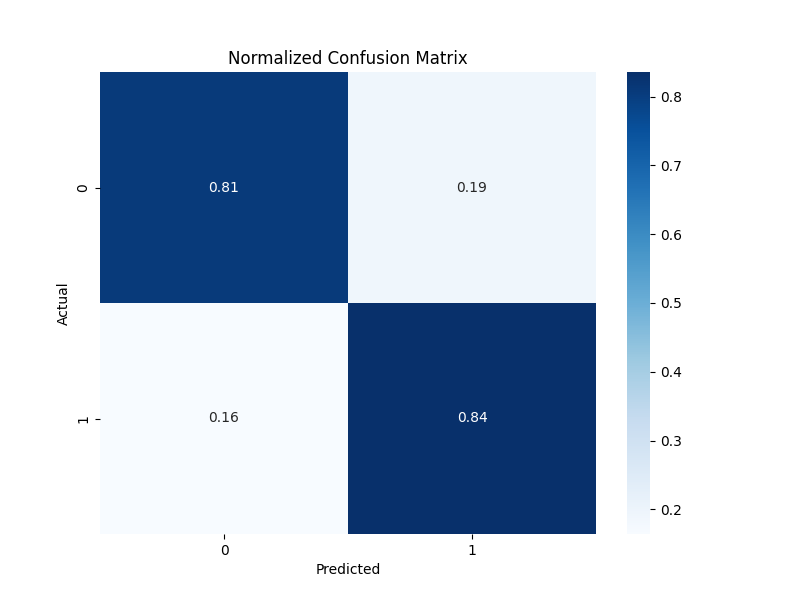

In [401]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Get predictions with binary classification
predictions_binary = test_prediction > 0.5

# Create and normalize confusion matrix
cm = confusion_matrix(y_test, predictions_binary, normalize='true')

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

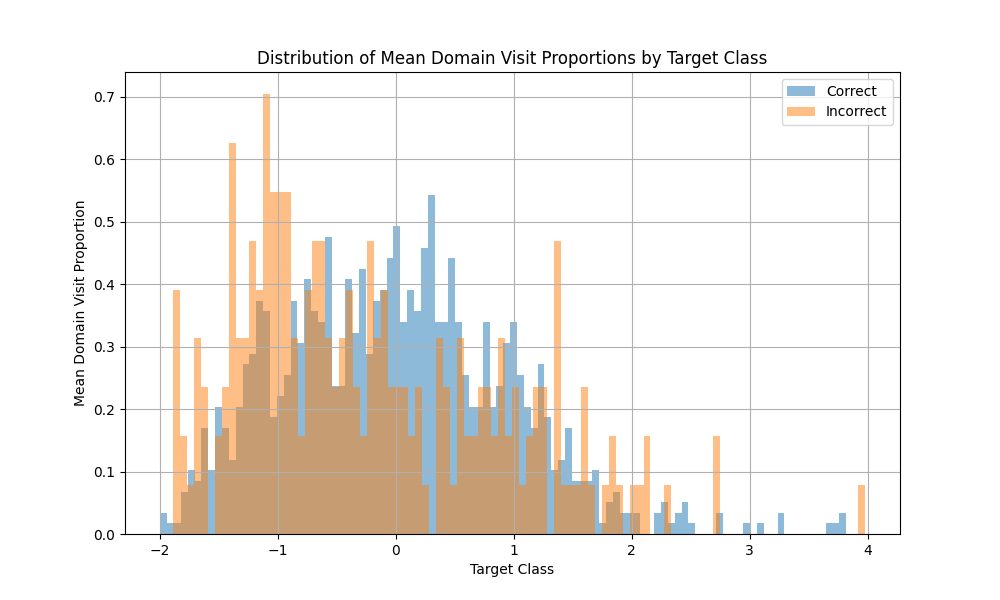

Mean difference (Target 1 - Target 0): -0.055


In [394]:
# Get predictions with binary classification
predictions_binary = test_prediction > 0.5

# Create masks for correct and incorrect predictions
correct_mask = predictions_binary == y_test
incorrect_mask = ~correct_mask

# Get feature columns with domains_visited_ prefix
domains_visited_cols = [
    col for col in final_features.columns
    if col.startswith('domains_visited_n_domains')
]

# Create separate histograms for correct and incorrect predictions
plt.figure(figsize=(10, 6))

# Plot histograms of usage of domains_visited_n_domains for correct and incorrect predictions, to see if there is a difference
for mask, label in zip([correct_mask, incorrect_mask],
                       ['Correct', 'Incorrect']):
    X_test.loc[mask, domains_visited_cols].stack().hist(bins=100,
                                                        alpha=0.5,
                                                        label=label,
                                                        density=True)
plt.title('Distribution of Mean Domain Visit Proportions by Target Class')
plt.xlabel('Target Class')
plt.ylabel('Mean Domain Visit Proportion')
plt.legend()
plt.grid(True)
plt.show()

# Print mean differences
means_by_target = final_features[["domains_visited_n_domains"]].join(
    device_targets.set_index("Device_ID")).groupby(
        "Target")["domains_visited_n_domains"].mean()
mean_diff = means_by_target.loc[1] - means_by_target.loc[0]
print(f"Mean difference (Target 1 - Target 0): {mean_diff.mean():.3f}")

# run["plots/domain_visit_means"].upload(
#     neptune.types.File.as_image(plt.figure()))
# run.stop()

In [ ]:
plt.figure()
X_train["domains_visited_n_domains"].hist(bins=100)
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Create test size increments
step = 50
max_size = len(y_test)
idx = np.arange(max_size)
auc_scores_all = []
for _ in range(10):
    np.random.shuffle(idx)
    y_check = y_test[idx]
    prediction_check = test_prediction[idx]
    sizes = np.arange(200, max_size, step)
    auc_scores = []

    # Calculate AUC for each size
    for size in sizes:
        auc = roc_auc_score(y_check[:size], prediction_check[:size])
        auc_scores.append(auc)
    auc_scores_all.append(auc_scores)
    plt.plot(sizes, auc_scores, 'b-', alpha=1)
# Calculate mean and std across runs
auc_scores_mean = np.mean(auc_scores_all, axis=0)
auc_scores_std = np.std(auc_scores_all, axis=0)

# Plot results

plt.axhline(y=score,
            color='r',
            linestyle='--',
            label=f'Final AUC: {score:.3f}')
plt.plot(sizes, auc_scores_mean, 'b-', alpha=1)

plt.title('AUC Score vs Test Set Size')
plt.xlabel('Test Set Size')
plt.ylabel('AUC Score')
plt.grid(True)
plt.legend()
plt.show()

# Print statistics
print(f'Mean AUC: {np.mean(auc_scores):.3f}')
print(f'Std AUC: {np.std(auc_scores):.3f}')
# Calculate confidence intervals
ci_upper = np.array(auc_scores) + 1.96 * np.std(auc_scores)
ci_lower = np.array(auc_scores) - 1.96 * np.std(auc_scores)

# Upload plot to neptune run
# run["plots/auc_vs_size"].upload(plt.gcf())
# run.stop()
# Print additional statistics
print(
    f'95% CI: [{np.mean(auc_scores)-1.96*np.std(auc_scores):.3f}, {np.mean(auc_scores)+1.96*np.std(auc_scores):.3f}]'
)

In [ ]:
from sklearn.metrics import accuracy_score

y_train_pred = selector.estimator_.predict(X_train[best_features])

print(accuracy_score(y_train, y_train_pred > 0.5))
print(accuracy_score(y_test, test_prediction > 0.5))
cm = confusion_matrix(y_test, test_prediction > 0.5, normalize='true')

# create confusion matrix heatmap
plt.figure(figsize=(8, 6))
# Create heatmap with percentage values
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix (% of true labels)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
# Plot training and validation metrics
plt.figure(figsize=(10, 6))

# Calculate accuracy for different thresholds
thresholds = np.linspace(0, 1, 100)
accuracies = [accuracy_score(y_test, test_prediction > t) for t in thresholds]

# Plot accuracy vs threshold curve
plt.plot(thresholds, accuracies, label='Accuracy')

# Add vertical line at 0.5 threshold
plt.axvline(x=0.5, color='r', linestyle='--', label='0.5 threshold')

# Add horizontal line at max accuracy
max_accuracy = max(accuracies)
plt.axhline(y=max_accuracy,
            color='g',
            linestyle='--',
            label=f'Max accuracy: {max_accuracy:.3f}')

plt.title('Model Performance on Validation Set')
plt.xlabel('Prediction Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Print additional metrics
optimal_threshold = thresholds[np.argmax(accuracies)]
print(f'Optimal threshold: {optimal_threshold:.3f}')
print(f'ROC AUC score: {score:.3f}')

In [26]:
def full_data_train_and_save(final_features):
    final_x = final_features.drop("Target", axis=1)
    final_y = final_features["Target"]
    full_data_model, full_data_features = train_model(final_x,
                                                      final_y,
                                                      params=params["model"])
    import json
    with open("submission/best_features.json", "w") as fp:
        json.dump(full_data_features, fp)
    import os
    os.makedirs("submission", exist_ok=True)
    # with open("submission/XGB_model.json", "w") as fp:
    full_data_model.estimator_.save_model('submission/XGB_model.json')
    return full_data_model

In [31]:
import os

os.makedirs("submission", exist_ok=True)
# with open("submission/XGB_model.json", "w") as fp:
selector.estimator_.save_model('submission/XGB_model.json')

In [217]:
# %%writefile submission/model.py
import xgboost
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json
from submission.prepare_and_train_model import *
from submission.utils import *
from submission.domain_timeseries_processing import *
from submission.content_based_features import *
from submission.frequency_base_feats import *
from submission.cls_features import *
from submission.load_and_prepare_input import *
# from domain_timeseries_processing import *
# from utils import *
# from load_and_prepare_input import *
# from prepare_and_train_model import *
# from content_based_features import *
# from frequency_base_feats import *
# from cls_features import *

PARAMS = {
    'seed': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'learning_rate': 0.1,
    'max_depth': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'weighted_final_scores': {},
    'mean_probability_score': {
        'fillna': True,
        'square_usage': True,
        'norm': 'z'
    },
    'feature_selection': {
        'n_features_to_select': 2000,
        'step': 20000
    },
    'model': {
        'seed': 0,
        'subsample': 0.8,
        'colsample_bytree': 0.6,
        'learning_rate': 0.1,
        'n_estimators': 250,
        'max_depth': 4,
        'objective': 'binary:logistic'
    },
    'no-normalization-finalscores': True,
    "user_activity_timeseries": {
        "bin_hours": 6,
        "gaussian_filter": True,
        "n_days_each_side": 3,
        "std": 1.5,
        "drop_na": True,
        "drop_zeros": False
    }
}


class model:

    def __init__(self, params=PARAMS, engine=pd):
        '''
        Init the model
        '''
        self.model = xgboost.XGBRegressor()
        self.domain_activity = None
        self.user_activity = None
        self.best_features = None
        self.psd_bins = None
        self.valid_domains = None
        self.cls_columns = None
        self.weighted_score_scaler = StandardScaler()
        self.max_domain_scaler = StandardScaler()
        self.cls_proportion_scaler = StandardScaler()
        self.domains_visited_scaler = StandardScaler()
        self.psd_df_scaler = StandardScaler()
        self.mean_scores_scaler = StandardScaler()
        self.params = params
        self.engine = engine

    def get_probability_score(self, x_valid_domains):
        user_activity_timeseries = get_user_activity_timeseries(
            x_valid_domains, self.params["user_activity_timeseries"])

        p_scores_df = get_user_domain_scores(self.domain_activity,
                                             user_activity_timeseries)

        p_scores_df -= 0.5
        p_scores_df = p_scores_df.reindex(columns=self.valid_domains)
        # min_max_scale_all_values(p_scores_df, train_devices, self.score_scaler)
        return p_scores_df  #checked

    def get_cls_features(self, cls_data):
        cls_proportion = get_cls_proportion(cls_data)
        cls_proportion = cls_proportion.reindex(
            columns=self.cls_proportion_cols)
        z_normalize_by_all(cls_proportion,
                           train_devices=None,
                           per_column=True,
                           fill_na_pre_transform=True,
                           scaler=self.cls_proportion_scaler)
        return cls_proportion  #checked

    def get_content_based_features(self, x_valid_domains):
        domain_usage_proportion = get_domain_usage_proportion(x_valid_domains)
        max_domain_usage = domain_usage_proportion.max(axis=1).to_frame()
        z_normalize_by_all(df=max_domain_usage,
                           train_devices=None,
                           per_column=True,
                           scaler=self.max_domain_scaler)
        domain_usage_proportion = np.log(1 + domain_usage_proportion)
        domain_usage_proportion = ((domain_usage_proportion.T) /
                                   domain_usage_proportion.T.max()).T

        domain_usage_proportion = domain_usage_proportion.reindex(
            columns=self.valid_domains).fillna(0)
        return domain_usage_proportion, max_domain_usage  #checked

    def get_frequency_based_features(self, x, valid_x):
        psd_df = get_ps_df(x, self.engine, cols=self.psd_bins)
        psd_df = psd_df.reindex(columns=self.psd_df_cols)
        z_normalize_by_all(psd_df,
                           train_devices=None,
                           per_column=True,
                           scaler=self.psd_df_scaler)
        domains_visited_proportion = get_proportion_of_domains_visited(
            valid_x, n_total_domains=len(self.valid_domains))
        domains_visited_proportion = domains_visited_proportion.reindex(
            columns=self.domains_visited_proportion_cols)
        z_normalize_by_all(domains_visited_proportion,
                           train_devices=None,
                           per_column=True,
                           fillval=0,
                           scaler=self.domains_visited_scaler)
        return psd_df, domains_visited_proportion  #checked


    def get_url_features(self,db_df,target_per_url):
        url_df = load_and_prepare_data("url")
        url_df = filter_urls(url_df,threshold=10)
        target_per_url_reduced = get_target_per_url(url_df, train_devices)
        user_url_score = calculate_user_url_score(url_df, target_per_url_reduced)
        user_url_score = user_url_score.astype(np.float32)
        z_normalize_by_all(user_url_score,
                           train_devices=None,
                           per_column=True,
                           scaler=self.url_score_scaler)
        return user_url_score

    def get_mixed_features(self, p_scores_df, domain_usage_proportion):
        weighted_final_scores = get_weighted_final_scores(
            p_scores_df, domain_usage_proportion)
        weighted_final_scores = weighted_final_scores.reindex(
            columns=self.weighted_final_scores_cols)
        z_normalize_by_all(weighted_final_scores,
                           train_devices=None,
                           per_column=False,
                           fill_na_pre_transform=True,
                           scaler=self.weighted_score_scaler)
        weighted_final_scores_other = get_weighted_final_scores(
            p_scores_df, domain_usage_proportion, square_usage=True)
        proportions_used = (domain_usage_proportion[p_scores_df.columns]**2
                            ).T.sum().to_frame()

        sum_probability_score = weighted_final_scores_other.T.sum().to_frame()
        mean_probability_score = sum_probability_score / proportions_used
        mean_probability_score = mean_probability_score.reindex(
            columns=self.mean_probability_score_cols)
        z_normalize_by_all(mean_probability_score,
                           train_devices=None,
                           per_column=False,
                           fill_na_pre_transform=True,
                           scaler=self.mean_scores_scaler)
        return weighted_final_scores, mean_probability_score  #checked

    def load_standard_scaler(self, scaler_path):
        '''
        Load the StandardScaler from the given path
        '''
        with open(scaler_path, 'r') as f:
            loaded_params = json.load(f)
        scaler = StandardScaler()
        scaler.mean_ = np.array([loaded_params["mean_"]], dtype=np.float64)
        scaler.var_ = np.array([loaded_params["var_"]], dtype=np.float64)
        scaler.scale_ = np.array([loaded_params["scale_"]], dtype=np.float64)
        scaler.n_samples_seen_ = np.array([loaded_params["n_samples_seen_"]],
                                          dtype=np.int64)
        return scaler

    def load_minmax_scaler(self, scaler_path):
        '''
        Load the MinMaxScaler from the given path
        '''
        with open(scaler_path, 'r') as f:
            loaded_params = json.load(f)
        scaler = MinMaxScaler()
        scaler.min_ = np.array([loaded_params["min_"]], dtype=np.float64)
        scaler.scale_ = np.array([loaded_params["scale_"]], dtype=np.float64)
        scaler.data_min_ = np.array([loaded_params["data_min_"]],
                                    dtype=np.float64)
        scaler.data_max_ = np.array([loaded_params["data_max_"]],
                                    dtype=np.float64)
        scaler.data_range_ = np.array([loaded_params["data_range_"]],
                                      dtype=np.float64)
        scaler.feature_range = tuple(loaded_params["feature_range"])
        return scaler

    def load(self, dir_path):
        '''
        Load the trained model and domain activity data
        '''
        import os
        import json

        model_path = os.path.join(dir_path, 'XGB_model.json')
        self.model.load_model(model_path)
        best_features_path = os.path.join(dir_path, 'best_features.json')
        with open(best_features_path, "r") as fp:
            self.best_features = json.load(fp)
        self.best_domains = [
            int(x.replace("p_", "")) for x in self.best_features
            if x.startswith("p_") and "mean" not in x
        ]
        domain_activity_path = os.path.join(dir_path,
                                            'best_domains_timeseries.parquet')
        self.domain_activity = self.engine.read_parquet(domain_activity_path)
        self.target_per_url = self.engine.read_parquet(
            os.path.join(dir_path, 'target_per_url_reduced.parquet'))
        # self.load_minmax_scaler(os.path.join(dir_path, 'minmax_scaler.json'))
        scalers = [
            "max_domain_scaler", "psd_df_scaler", "domains_visited_scaler",
            "cls_proportion_scaler", "weighted_score_scaler",
            "mean_scores_scaler"
        ]
        for s in scalers:
            setattr(
                self, s,
                self.load_standard_scaler(os.path.join(dir_path, f'{s}.json')))

        with open(os.path.join(dir_path, 'valid_domains.json'), 'r') as f:
            self.valid_domains = [int(x) for x in json.load(f)]

        self.psd_bins = self.engine.read_parquet(
            os.path.join(dir_path, 'psd_bins.parquet')).iloc[:, 0].tolist()
        self.max_domain_usage_cols = self.engine.read_parquet(
            os.path.join(dir_path,
                         'max_domain_usage_cols.parquet')).iloc[:, 0].tolist()
        self.psd_df_cols = self.engine.read_parquet(
            os.path.join(dir_path, 'psd_df_cols.parquet')).iloc[:, 0].tolist()
        self.cls_proportion_cols = self.engine.read_parquet(
            os.path.join(dir_path,
                         'cls_proportion_cols.parquet')).iloc[:, 0].tolist()
        self.weighted_final_scores_cols = self.engine.read_parquet(
            os.path.join(
                dir_path,
                'weighted_final_scores_cols.parquet')).iloc[:, 0].tolist()
        self.mean_probability_score_cols = self.engine.read_parquet(
            os.path.join(
                dir_path,
                'mean_probability_score_cols.parquet')).iloc[:, 0].tolist()
        self.domains_visited_proportion_cols = self.engine.read_parquet(
            os.path.join(
                dir_path,
                'domains_visited_proportion_cols.parquet')).iloc[:,
                                                                 0].tolist()

    def prepare_data(self, X):
        X = X.copy()

        if X['Datetime'].dtype == 'O':
            X['Datetime'] = self.engine.to_datetime(X['Datetime'])
        if "Device_ID" not in X.columns:
            X["Device_ID"] = 1
        X = X[X["Domain_Name"] != 1732927]
        X.set_index(['Datetime'], inplace=True)
        x_valid_domains = X[X['Domain_Name'].isin(self.valid_domains)]
        return X, x_valid_domains

    def predict(self, X):
        '''
        Predict the class probability for the input data
        '''
        # Process user timeseries
        X, x_valid_domains = self.prepare_data(X)
        url_score = self.get_url_features(X, self.target_per_url)
        p_scores_df = self.get_probability_score(x_valid_domains)
        # print("pscores_df", p_scores_df.T.describe())
        domain_usage_proportion, max_domain_usage = self.get_content_based_features(
            x_valid_domains)
        # print("domain_usage_proportion", domain_usage_proportion.T.describe())
        # print("max_domain_usage", max_domain_usage.T.describe())
        cls_proportion = self.get_cls_features(X)
        # print("cls_proportion", cls_proportion.T.describe())
        psd_df, domains_visited_proportion = self.get_frequency_based_features(
            X, valid_x=x_valid_domains)
        # print("psd_df", psd_df.T.describe())
        weighted_final_scores, mean_probability_score = self.get_mixed_features(
            p_scores_df, domain_usage_proportion)
        # print("weighted_final_scores", weighted_final_scores.T.describe())
        # print("mean_probability_score", mean_probability_score.T.describe())
        final_features = join_features(
            device_targets=None,
            weighted_final_scores=weighted_final_scores,
            cls_proportion=cls_proportion,
            psd_df=psd_df,
            domains_visited_proportion=domains_visited_proportion,
            mean_probability_score=mean_probability_score,
            max_domain_usage=max_domain_usage,
            user_url_score=url_score,)
        final_features = final_features[self.best_features]
        # final_features.to_parquet("27_device.parquet")
        # add feature that is number of zeros in final_features

        # Make prediction
        prediction = self.model.predict(final_features)
        return prediction[0]

In [33]:
sys.path.append("/home/tom.touati/mafat-challenge/code/submission")

In [ ]:
cls_data["Domain_Name"] = db_df["Domain_Name"]
print(cls_data["Domain_Name"])
test_df = cls_data[cls_data["Device_ID"].isin(test_device_ids)].reset_index()

In [ ]:
y_test

In [ ]:
import pandas as pd
# from submission.model import model as mdl
from submission.prepare_and_train_model import *
from submission.utils import *
from submission.domain_timeseries_processing import *
from submission.content_based_features import *
from submission.frequency_base_feats import *
from submission.cls_features import *
from submission.load_and_prepare_input import *
from multiprocessing import Pool
import numpy as np

# @ray.remote
# def predict(x):
#     m = model(engine=pd)
#     m.load("submission")
#     return m.predict(x)

# m = model(engine=pd)
# m.load("submission")
# import ray


@ray.remote
def process_device(test_df, device_id):
    m = model(engine=pd)
    m.load("submission")
    x_device = test_df[test_df["Device_ID"] == device_id].drop(
        columns=["Target", "Device_ID"])
    prediction = m.predict(x_device)
    print("device_id done:", device_id)
    return prediction


test_d = ray.put(test_df._to_pandas())
predictions = [
    process_device.remote(test_d, device_id) for device_id in y_test.index
]

print(predictions)
preds = [ray.get(p) for p in predictions]
#this took 2 minutes